# Камынина Т. Н. Курсовой проект

В курсовом проекте, изначально я хотела попытаться затронуть все 4 темы, заявленные для курсовой работы. Но в силу неудачно выбранного датасета, который как выяснилось не соответствует нормальному распределению и последующей нехватке времени, у меня получился только EDA. Ну плюс какие-то небольшие попытки, сделать что-то из того, о чем Вы нам рассказывали на лекциях.

Также из недочетов, которые я не успела убрать, но о которых знаю - это повторяющийся код (надо было сделать функции) и не далеко не самый оптимальная реализация группировки для некоторых признаков (надо было обойтись без ручного перечисления).

In [661]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from collections import Counter

## Разведочный анализ данных (EDA)

In [662]:
DATASET_PATH='./bmw.csv'
df = pd.read_csv(DATASET_PATH, sep=',')
df.head(5)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


Датасет содержит информацию о машинах марки BMW, их основных характеристиках и стоимости каждой машины. В датасете 10781 запись. 8 предположительно независимых показателей:
 * <b>model</b> - модель, 
 * <b>year</b> - год выпуска, 
 * <b>transmission</b> - коробка передач, 
 * <b>mileage</b> - пробег, 
 * <b>fuelType</b> - тип топлива, 
 * <b>tax</b> - налог?, 
 * <b>mpg</b> - расход топлива на единицу пробега, 
 * <b>engineSize</b> - мощность двигателя <br>
 
 И один результирующий - <b>price</b> (цена).
 
 <b>Model</b>, <b>transmission</b> и <b>fuelType</b> - категориальные переменные. Остальные - количественные.

### Проверка на целостность данных и предварительная обработка

Проверим датасет на целостность данных:

In [663]:
len(df)

10781

In [664]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


В датасете 10781 запись и для каждого признака соответствующее количество значений. Пропусков нет.

### Целевая переменная

#### Проверка на нормальность

In [665]:
df.price.describe()

count     10781.000000
mean      22733.408867
std       11415.528189
min        1200.000000
25%       14950.000000
50%       20462.000000
75%       27940.000000
max      123456.000000
Name: price, dtype: float64

In [666]:
mean = round(df['price'].mean(), 2)
median = df['price'].median()
mode = df['price'].mode()[0]
print(f'mean - {mean}, median - {median}, mode - {mode}')

mean - 22733.41, median - 20462.0, mode - 20980


#### Визуальная проверка на нормальность:

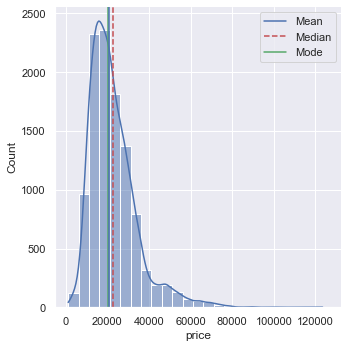

In [667]:
price = df['price']
sns.displot(price, binwidth=5000, kde=True)
plt.axvline(mean, color='r', linestyle='--')
plt.axvline(median, color='g', linestyle='-')
plt.axvline(mode, color='b', linestyle='-')
plt.legend({'Mean':mean,'Median':median,'Mode':mode})
plt.show()

С той же целью построим qq график:

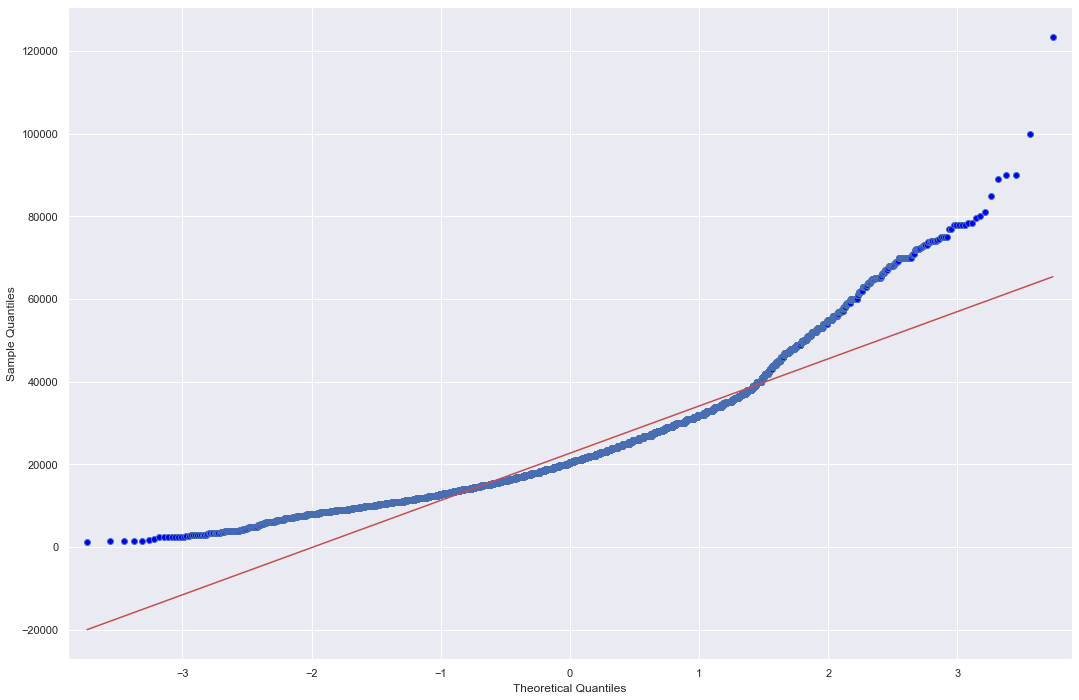

In [668]:
qqplot(df['price'], line='s')
plt.show()

#### Статистическая проверка на нормальность:

#### Тест Шапиро-Вилка

In [669]:
stat, p = shapiro(df['price'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.890, p=0.000
Sample does not look Gaussian (reject H0)


D:\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Тест д'Агостино на K ^ 2

In [670]:
stat, p = normaltest(df['price'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=3408.667, p=0.000
Sample does not look Gaussian (reject H0)


#### Тест Андерсона-Дарлинга

In [671]:
result = anderson(df['price'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 256.941
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


<B>Вывод:</b> Проверка переменной 'price' показала, что распределение значение данной переменной не соответствует критериям нормального распределения. Попытки привести их к нормальному методом взятия натуральных логарифмов и методом Standard Scaler() также не завершились успехом. К, к сожалению, на данном датасете я не смогу привести пример проверки гипотез (хотя сама по себе проверка на соответствие нормальному распределению уже является примером проверки гипотезы :-)). 

Поработаем с категориальными переменными. У нас их 3: model, transmission, fuelType. Признак model закодируем средней ценой в разрезе моделей, a transmission и fuelType преобразуем в dummies.

### Общая оценка данных

In [672]:
df.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

#### Year

In [673]:
df['year'].describe()

count    10781.000000
mean      2017.078935
std          2.349038
min       1996.000000
25%       2016.000000
50%       2017.000000
75%       2019.000000
max       2020.000000
Name: year, dtype: float64

В таблице представленные данные по машинам 1996 - 2020 года выпуска. То есть за 25 лет. При этом:
* 25% машин в базе - 1996 - 2016 гг выпуска включительно <br>
* 50% машин в базе = 2017 - 2019 года выпуска включительно <br>
* 25% машин в базе - 2020 года выпуска.

In [674]:
df['year'].mode()

0    2019
dtype: int64

Чаще всего встречаются машины 2019 года.

In [675]:
df['year'].value_counts().sort_index(ascending=True)

1996       1
1997       1
1998       1
1999       4
2000       2
2001       3
2002       6
2003       2
2004      12
2005       6
2006      14
2007      16
2008      23
2009      30
2010      41
2011      51
2012     119
2013     357
2014     501
2015     922
2016    1882
2017    1721
2018     848
2019    3485
2020     733
Name: year, dtype: int64

25 уникальных значений признака это многовато для визуального анализа. Объединим года в периоды по 5 лет.

In [676]:
period_dict = {2010: (1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010),
               2015: (2011, 2012, 2013, 2014, 2015),
               2020: (2016, 2017, 2018, 2019, 2020)}

periods = []

for year in df['year']:
    for key, value in period_dict.items():
        if year in value:
            periods.append(key)

df['periods'] = periods
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,periods
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,2015
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,2020
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,2020
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,2020
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,2015


In [677]:
cnt_periods = Counter(df['periods'])
cnt_periods = dict(cnt_periods)
cnt_periods

{2015: 1950, 2020: 8669, 2010: 162}

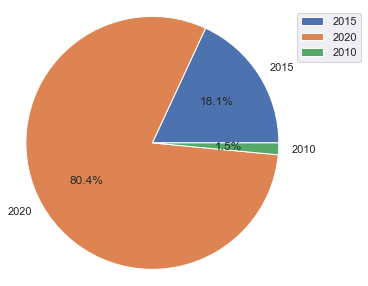

In [678]:
fig1, ax1 = plt.subplots()
ax1.pie(cnt_periods.values(), labels=cnt_periods.keys(), autopct='%1.1f%%')
ax1.axis('equal') 
ax1.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

В базе данных всего 162 машины или 1.5% с годом выпуска 1996 - 2010. <br>
1950 машин или 18.1% - с годом выпуска 2011 = 2015 <br>
И на 80.4% наша база состоит из данных по машинам с годом выпуска 2016 - 2020.

#### Model

In [679]:
df['model'].unique(), len(df['model'].unique())

(array([' 5 Series', ' 6 Series', ' 1 Series', ' 7 Series', ' 2 Series',
        ' 4 Series', ' X3', ' 3 Series', ' X5', ' X4', ' i3', ' X1', ' M4',
        ' X2', ' X6', ' 8 Series', ' Z4', ' X7', ' M5', ' i8', ' M2',
        ' M3', ' M6', ' Z3'], dtype=object),
 24)

In [680]:
df['model'].value_counts().sort_index(ascending=True)

 1 Series    1969
 2 Series    1229
 3 Series    2443
 4 Series     995
 5 Series    1056
 6 Series     108
 7 Series     106
 8 Series      39
 M2            21
 M3            27
 M4           125
 M5            29
 M6             8
 X1           804
 X2           288
 X3           551
 X4           179
 X5           468
 X6           106
 X7            55
 Z3             7
 Z4           108
 i3            43
 i8            17
Name: model, dtype: int64

В датасете представлены данные по 24 моделям. Самое большое количество записей для БМВ 3 и 1 серии. На седаны 1-5 серии приходится 71% всех записей базы. Чтобы остальные данные не терялись на фоне этой группы, необходимо укрупнить группировку для остальных моделей.

In [681]:
model_dict = {' 1 Series': (' 1 Series'),
              ' 2 Series': (' 2 Series'),
              ' 3 Series': (' 3 Series'),
              ' 4 Series': (' 4 Series'),
              ' 5 Series': (' 5 Series'),
              ' Other sedans': (' 6 Series', ' 7 Series', ' 8 Series'),
               'SUV': (' X1', ' X2', ' X3', ' X4', ' X5', ' X6', ' X7'),
               'M Series': (' M2', ' M3', ' M4', ' M5', ' M6'),
               'Z Series': (' Z3', ' Z4'),
               'I Series': (' i3', ' i8')
             }

models = []

for model in df['model']:
    for key, value in model_dict.items():
        if model in value:
            models.append(key)

df['category'] = models
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,periods,category
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,2015,5 Series
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,2020,Other sedans
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,2020,5 Series
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,2020,1 Series
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,2015,Other sedans


In [682]:
cnt_models = Counter(df['category'])
cnt_models = dict(cnt_models)
cnt_models

{' 5 Series': 1056,
 ' Other sedans': 253,
 ' 1 Series': 1969,
 ' 2 Series': 1229,
 ' 4 Series': 995,
 'SUV': 2451,
 ' 3 Series': 2443,
 'I Series': 60,
 'M Series': 210,
 'Z Series': 115}

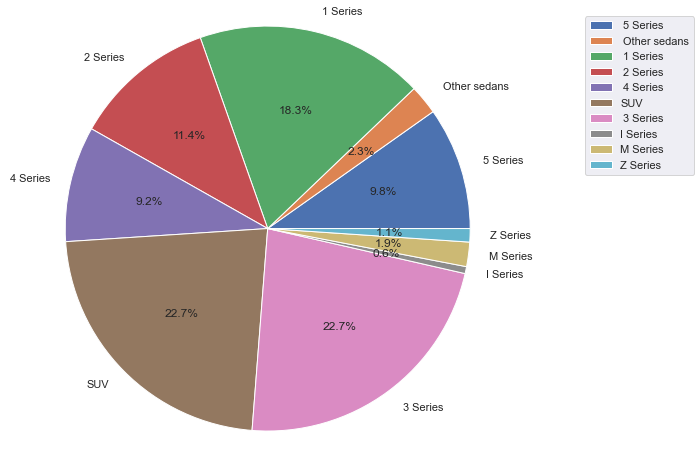

In [683]:
fig1, ax1 = plt.subplots()
ax1.pie(cnt_models.values(), labels=cnt_models.keys(), autopct='%1.1f%%')
ax1.axis('equal') 
ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1.0))
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()

#### Transmission

In [684]:
df['transmission'].unique()

array(['Automatic', 'Manual', 'Semi-Auto'], dtype=object)

In [685]:
cnt_transmission = Counter(df['transmission'])
cnt_transmission = dict(cnt_transmission)
cnt_transmission

{'Automatic': 3588, 'Manual': 2527, 'Semi-Auto': 4666}

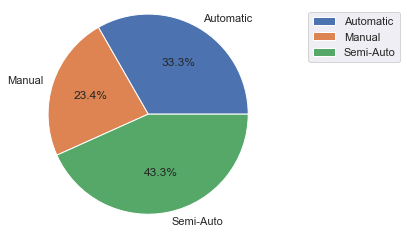

In [686]:
fig1, ax1 = plt.subplots()
ax1.pie(cnt_transmission.values(), labels=cnt_transmission.keys(), autopct='%1.1f%%')
ax1.axis('equal') 
ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1.0))
fig = plt.gcf()
fig.set_size_inches(4,4)
plt.show()

Распределение машин по видам коробки передач относительно равномерно: автоматическая коробка передач - 33.3%, полуавтомат - 43.3%, ручная 23.4%

#### Mileage

In [687]:
df['mileage'].describe()

count     10781.000000
mean      25496.986550
std       25143.192559
min           1.000000
25%        5529.000000
50%       18347.000000
75%       38206.000000
max      214000.000000
Name: mileage, dtype: float64

Минимальный пробег - 1 миля, максимальный - 214000 миль. Средний пробег по всей базе 25.5 тыс. миль. 25% машин в базе имеют пробег менее 5600 миль. и более половины машин имеют пробег более 18 тыс. миль.

На всякий случай проверим переменную на наличие выбросов:

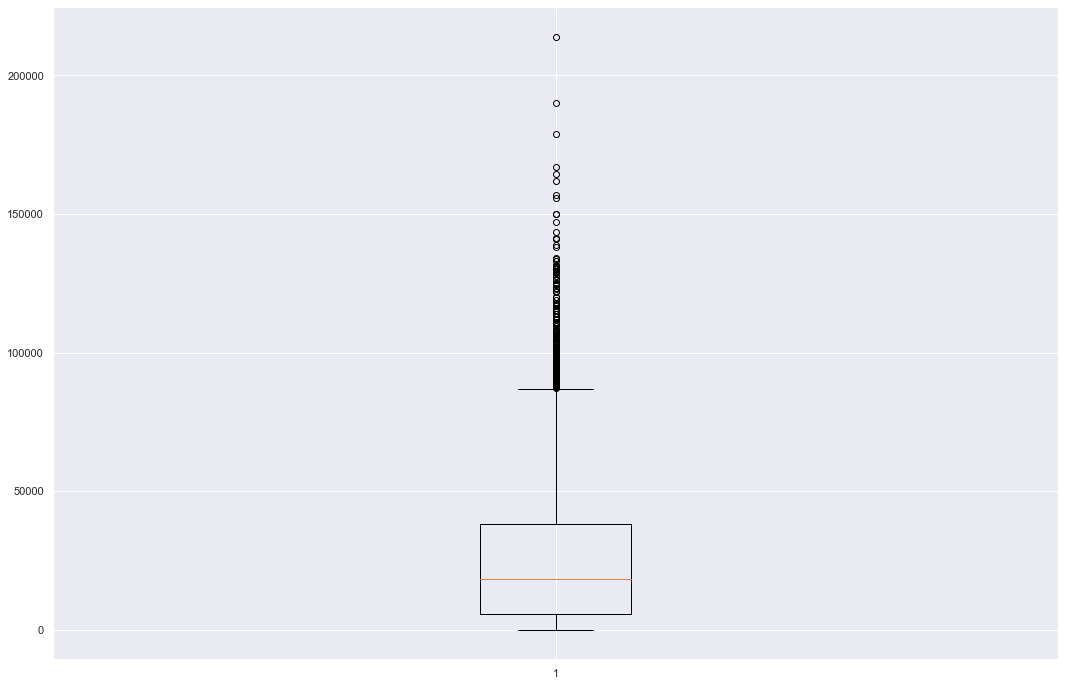

In [688]:
plt.boxplot(df['mileage'])
plt.show()

In [689]:
df.loc[(df['mileage'] < 10) & (df['year'] != 2020)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,periods,category
2309,2 Series,2019,23940,Semi-Auto,9,Diesel,145,62.8,2.0,2020,2 Series
2843,4 Series,2019,23750,Semi-Auto,9,Diesel,145,65.7,2.0,2020,4 Series
4058,X1,2019,32495,Automatic,6,Diesel,145,52.3,2.0,2020,SUV
4135,3 Series,2019,30495,Automatic,8,Diesel,145,50.4,2.0,2020,3 Series
4398,5 Series,2019,28380,Semi-Auto,6,Diesel,145,65.7,2.0,2020,5 Series
4920,3 Series,2019,28990,Semi-Auto,6,Petrol,145,42.2,2.0,2020,3 Series
5360,3 Series,2019,33134,Semi-Auto,5,Diesel,145,52.3,2.0,2020,3 Series
5652,3 Series,2019,31990,Automatic,5,Petrol,145,42.2,2.0,2020,3 Series
5913,X5,2019,73000,Automatic,5,Hybrid,135,188.3,3.0,2020,SUV


In [690]:
df.loc[(df['mileage'] > 150000)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,periods,category
8313,3 Series,2011,3493,Manual,190000,Diesel,20,68.9,2.0,2015,3 Series
8925,3 Series,2010,3800,Manual,156800,Diesel,125,58.9,2.0,2010,3 Series
9216,3 Series,2014,9000,Automatic,155790,Diesel,145,54.3,3.0,2015,3 Series
9414,5 Series,2013,8999,Automatic,178987,Hybrid,190,40.4,3.0,2015,5 Series
9419,X5,2012,7250,Automatic,214000,Diesel,300,37.7,3.0,2015,SUV
9554,1 Series,2007,1500,Manual,167000,Diesel,125,57.6,2.0,2010,1 Series
9696,3 Series,2004,1445,Manual,162000,Diesel,205,49.6,2.0,2010,3 Series
10004,5 Series,2010,6980,Automatic,164500,Diesel,140,53.3,2.0,2010,5 Series


Крайние значения адекватны. Ошибок нет.

#### FuelType

In [691]:
df['fuelType'].unique(), len(df['fuelType'].unique())

(array(['Diesel', 'Petrol', 'Other', 'Hybrid', 'Electric'], dtype=object), 5)

In [692]:
cnt_fuel = Counter(df['fuelType'])
cnt_fuel = dict(cnt_fuel)
cnt_fuel

{'Diesel': 7027, 'Petrol': 3417, 'Other': 36, 'Hybrid': 298, 'Electric': 3}

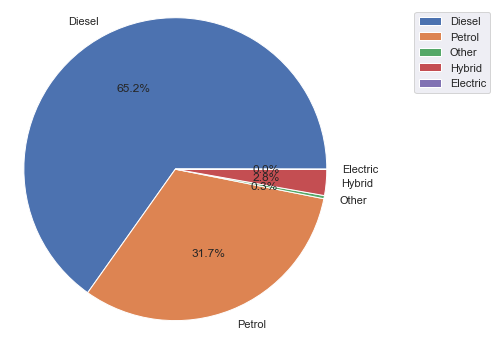

In [693]:
fig1, ax1 = plt.subplots()
ax1.pie(cnt_fuel.values(), labels=cnt_fuel.keys(), autopct='%1.1f%%')
ax1.axis('equal') 
ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1.0))
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()

На долю автомобилей с дизельным двигателем приходится 65.2% записей, бензиновым 31.7%. На все остальные виды топлива приходится чуть более 3% записей.

#### EngineSize

In [694]:
df['engineSize'].describe()

count    10781.000000
mean         2.167767
std          0.552054
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          6.600000
Name: engineSize, dtype: float64

In [695]:
df['engineSize'].mode()

0    2.0
dtype: float64

In [696]:
df['engineSize'].unique(), len(df['engineSize'].unique())

(array([2. , 3. , 1.5, 0.6, 1.6, 4.4, 0. , 2.2, 2.5, 4. , 3.2, 1. , 5. ,
        1.9, 6.6, 2.8, 3.5]),
 17)

In [697]:
df['engineSize'].value_counts().sort_index(ascending=True)

0.0      47
0.6       7
1.0       1
1.5    1463
1.6     109
1.9       5
2.0    6575
2.2       6
2.5      14
2.8       2
3.0    2458
3.2       5
3.5       1
4.0       6
4.4      79
5.0       1
6.6       2
Name: engineSize, dtype: int64

In [698]:
engine_dict = {1.5: (0.0, 0.6, 1.0, 1.5),
               2.0: (1.6, 1.6, 1.9, 2.0),
               3.0: (2.1, 2.2, 2.5, 2.8, 3.0, 3.2, 3.5, 4.0, 4.4, 5.0, 6.6)}

engines = []

for engine in df['engineSize']:
    for key, value in engine_dict.items():
        if engine in value:
            engines.append(key)

df['engines'] = engines
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,periods,category,engines
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,2015,5 Series,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,2020,Other sedans,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,2020,5 Series,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,2020,1 Series,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,2015,Other sedans,3.0


In [699]:
cnt_engine = Counter(df['engines'])
cnt_engine = dict(cnt_engine)
cnt_engine

{2.0: 6689, 3.0: 2574, 1.5: 1518}

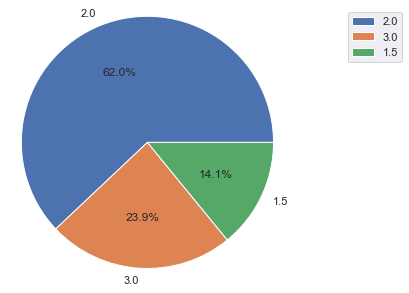

In [700]:
fig1, ax1 = plt.subplots()
ax1.pie(cnt_engine.values(), labels=cnt_engine.keys(), autopct='%1.1f%%')
ax1.axis('equal') 
ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1.0))
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

In [701]:
df['engines'].value_counts().sort_index(ascending=True)

1.5    1518
2.0    6689
3.0    2574
Name: engines, dtype: int64

In [702]:
df['model'].loc[(df['engineSize'] == 0)].value_counts()

 i3          35
 1 Series     5
 3 Series     4
 2 Series     2
 X5           1
Name: model, dtype: int64

Максимальный размер двигателя в представленном датасете - 6.6 л. Таких машин 2. Минимальный - 0. Таких машин 47, из них 35 - это электрокары, а остальные - некорректно указанный размер двигателя. Чаще всего встречается двигатель размером 2 л. 14.1% машин в базе имеют двигатель объемом не более 1.5л, 62.% - от 1.6 до 2, а 23.9% - свыше 2 л.

#### Tax

In [703]:
df['tax'].describe()

count    10781.000000
mean       131.702068
std         61.510755
min          0.000000
25%        135.000000
50%        145.000000
75%        145.000000
max        580.000000
Name: tax, dtype: float64

In [704]:
df['tax'].mode()

0    145
dtype: int64

In [705]:
df['tax'].unique(), len(df['tax'].unique())

(array([125, 145, 160,  30,  20, 135,   0, 165, 200, 150, 205, 300, 140,
        235, 260, 305, 265, 555, 325, 570, 240, 565, 330, 110, 195, 185,
        120, 540, 315, 155, 190, 250, 245, 255, 270, 580, 130, 280],
       dtype=int64),
 38)

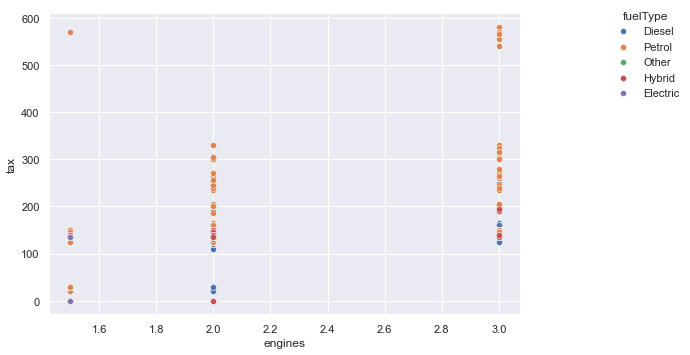

In [706]:
grid = sns.FacetGrid(df, hue="fuelType", height = 5, aspect = 1.5)
grid.map(sns.scatterplot, "engines", "tax")
grid.add_legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

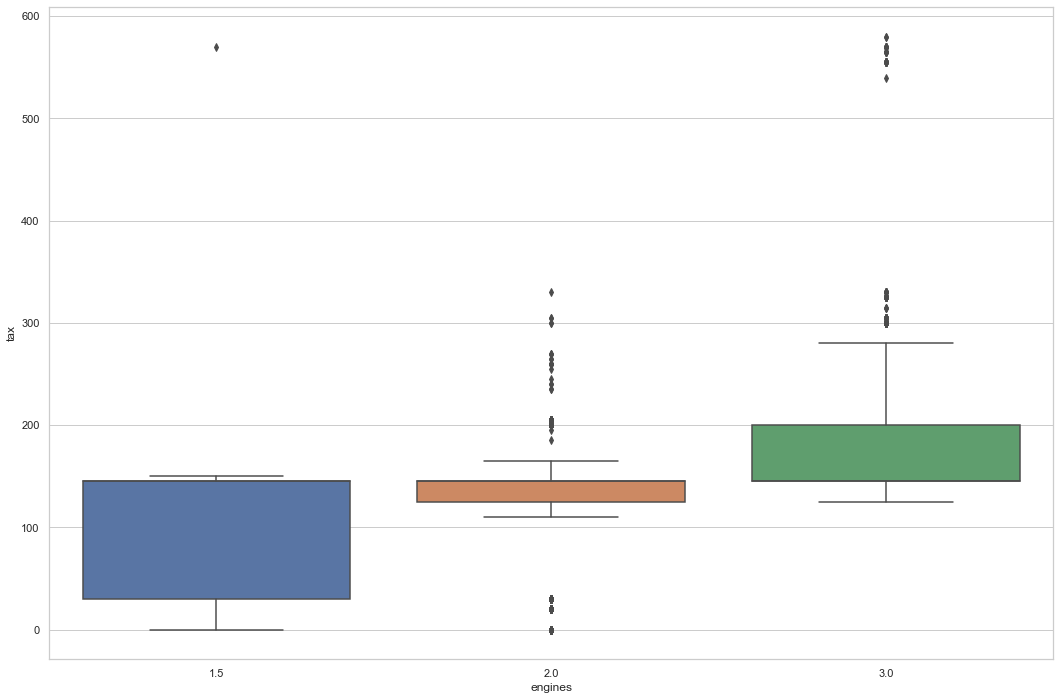

In [707]:
sns.set_style('whitegrid')
sns.boxplot(data = df , x = 'engines' , y = 'tax')
sns.set(rc={'figure.figsize':(6, 4)})

Не понятное для меня поле tax. Все-таки, наверное, налог. Минимальное значение 0, максимальное 580. Среднее значение 132. В базе 10781 запись, а значений tax всего 38, что говорит о том, что это присутствует некая градация значений данной переменной в отличие от значений какой-то другой. Глядя на скаттерплот, можно сделать вывод, что на бензиновый двигатель налог выше. Также есть зависимость размера налога от объема двигателя.

#### Mpg

In [708]:
df['mpg'].describe()

count    10781.000000
mean        56.399035
std         31.336958
min          5.500000
25%         45.600000
50%         53.300000
75%         62.800000
max        470.800000
Name: mpg, dtype: float64

In [709]:
df['mpg'].mode()

0    65.7
dtype: float64

In [710]:
df['mpg'].unique(), len(df['mpg'].unique())

(array([ 57.6,  42.8,  51.4,  72.4,  50.4,  60.1,  52.3,  62.8,  68.9,
         54.3,  58.9, 148.7,  64.2,  70.6,  83.1,  67.3,  53.3,  47.9,
         65.7, 470.8,  39.8, 141.2,  61.4,  37.2,  47.1,  43.5,  48.7,
         34. ,  55.4,  49.6,  74.3,  85.6, 134.5,  44.8,  55.5,  46.3,
         44.1,  37.7, 113. ,  35.3,  78.5,  36.2,  41.5,  31.4,  39.2,
         24.8,  34.5,  42.2,  32.5,  40.9,  38.2,  56.5,  45.6,  57.7,
         24.1,  33.6,  40.4,  36.7,  35.8,  26.9, 156.9,  26.7,  24.4,
         38.7,  29.1,  33.2, 135.5,  28.5,  32.1,  27.4,   5.5,  30.4,
         26.4,  34.9,  27.2,  25.4,  31. ,   8.8,  31.7, 188.3,  32.8,
        128.4,  23.2,  23.7,  29.7,  30.1,  28.8,  22.8,  23.3, 141.3,
         34.4,  29.4,  19.1,  24.6,  27.7,  25.2,  22.1,  30.7,  21.9,
         26.6,  22.6,  20.8]),
 102)

In [711]:
mpg_dict = {45: (5.5, 8.8, 19.1, 20.8, 21.9, 22.1, 22.6, 22.8, 23.2, 23.3, 23.7, 24.1, 24.4,\
                    24.6, 24.8, 25.2, 25.4, 26.4, 26.6, 26.7, 26.9, 27.2, 27.4, 27.7, 28.5, 28.8, \
                    29.1, 29.4, 29.7, 30.1, 30.4, 30.7, 31.0, 31.4, 31.7, 32.1, 32.5, 32.8, 33.2, 33.6, 34.0, 34.4, \
                    34.5, 34.9, 35.3, 35.8, 36.2, 36.7, 37.2, 37.7, 38.2, 38.7, 39.2, 39.8, 40.4, \
                    40.9, 41.5, 42.2, 42.8, 43.5, 44.1, 44.8),
               55: (45.6, 46.3, 47.1, 47.9, 48.7, 49.6, 50.4, 51.4, 52.3, 53.3, 54.3),
               65: (55.4, 55.5, 56.5, 57.6, 57.7, 58.9, 60.1, 61.4, 62.8, 64.2),
              190: (65.7, 67.3, 68.9, 70.6, 72.4, 74.3, 78.5, 83.1, 85.6, 113.0, 128.4, 134.5, 135.5,\
                    141.2, 141.3, 148.7, 156.9, 188.3, 470.8)}

mpgs = []

for mpg in df['mpg']:
    for key, value in mpg_dict.items():
        if mpg in value:
            mpgs.append(key)

df['mpgs'] = mpgs
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,periods,category,engines,mpgs
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,2015,5 Series,2.0,65
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,2020,Other sedans,2.0,45
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,2020,5 Series,3.0,55
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,2020,1 Series,1.5,190
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,2015,Other sedans,3.0,55


In [712]:
cnt_mpg = Counter(df['mpgs'])
cnt_mpg = dict(cnt_mpg)
cnt_mpg

{65: 2550, 45: 2623, 55: 3569, 190: 2039}

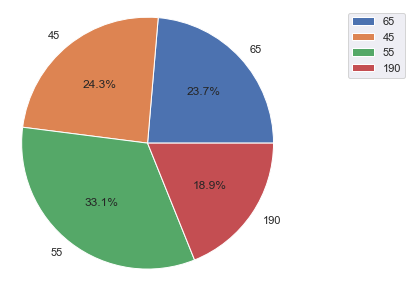

In [713]:
fig1, ax1 = plt.subplots()
ax1.pie(cnt_mpg.values(), labels=cnt_mpg.keys(), autopct='%1.1f%%')
ax1.axis('equal') 
ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1.0))
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

Минимальный пробег на 1 галоне топлива - 5.5, максимальный - 470.8. В среднем же, машины, представленные в датасете, могут проехать 56.4 миль на 1 галоне топлива. В целом, весь датасет по данному показателю относительно равномерно делится на 4 группы: 
* до 45mpg - 24.3%, 
* от 46 до 55mpg - 33.1%
* от 56 до 65mpg - 23.7%
* свыше 66mpg - 18.9%.

### Категориальные переменные

#### Кодирование переменной model

In [714]:
def code_median(df, cat_feature, real_feature):
    return (df[cat_feature].map(df.groupby(cat_feature)[real_feature].median()))

df['model_median_price'] = code_median(df, 'model', 'price')
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,periods,category,engines,mpgs,model_median_price
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,2015,5 Series,2.0,65,22996.5
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,2020,Other sedans,2.0,45,22854.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,2020,5 Series,3.0,55,22996.5
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,2020,1 Series,1.5,190,14800.0
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,2015,Other sedans,3.0,55,37224.5


#### Кодирование переменной transmission

In [715]:
dummy_transmission = pd.get_dummies(df['transmission'], prefix='transm_')
dummy_transmission.head()

,transm__Automatic,transm__Manual,transm__Semi-Auto
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [716]:
df = pd.merge(
    left=df,
    right=dummy_transmission,
    left_index=True,
    right_index=True,
)
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,periods,category,engines,mpgs,model_median_price,transm__Automatic,transm__Manual,transm__Semi-Auto
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,2015,5 Series,2.0,65,22996.5,1,0,0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,2020,Other sedans,2.0,45,22854.0,1,0,0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,2020,5 Series,3.0,55,22996.5,1,0,0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,2020,1 Series,1.5,190,14800.0,1,0,0
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,2015,Other sedans,3.0,55,37224.5,1,0,0


#### Кодирование переменной fuelType

In [717]:
dummy_fuel = pd.get_dummies(df['fuelType'], prefix='fuel_')
dummy_fuel.head()

,fuel__Diesel,fuel__Electric,fuel__Hybrid,fuel__Other,fuel__Petrol
0,1,0,0,0,0
1,0,0,0,0,1
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [718]:
df = pd.merge(
    left=df,
    right=dummy_fuel,
    left_index=True,
    right_index=True,
)
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,periods,...,mpgs,model_median_price,transm__Automatic,transm__Manual,transm__Semi-Auto,fuel__Diesel,fuel__Electric,fuel__Hybrid,fuel__Other,fuel__Petrol
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,2015,...,65,22996.5,1,0,0,1,0,0,0,0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,2020,...,45,22854.0,1,0,0,0,0,0,0,1
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,2020,...,55,22996.5,1,0,0,1,0,0,0,0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,2020,...,190,14800.0,1,0,0,1,0,0,0,0
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,2015,...,55,37224.5,1,0,0,1,0,0,0,0


### Независимые признаки

Построим таблицу взаимосвязей и проанализируем степень влияния факторов друг на друга.

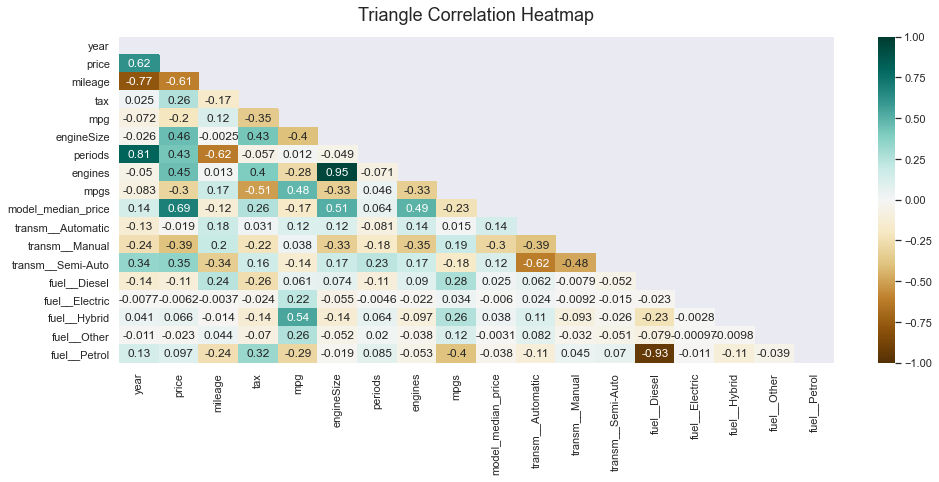

In [719]:
plt.figure(figsize=(16, 6)) 
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool)) 
heatmap = sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, mask = mask, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Какие значимые взаимосвязи мы здесь видим:
* <b>Цена</b>: 
    * зависит от года выпуска а/м (чем старше год - тем ниже цена), коэффициент корреляции 0.62
    * чем больше пробег, тем ниже цена, коэффициент корреляции - 0.61
    * на цену влияет размер двигателя (больше двигатель - дороже машина), коэффициент корреляции 0.46
    * машина с ручной коробкой передач стоит дешевле, коэффициент корреляции -0.39
* <b>Пробег</b>: 
    * чем старше машина, тем больше ее пробег, коэффициент корреляции -0.77
* <b>Налог</b>: 
    * чем больше машина может пройти на 1 галоне топлива, тем меньше налог, коэффициент корреляции -0.35
    * чем больше объем двигателя, тем больше налог , коэффициент корреляции 0.43
* <b>Расход топлива</b>: 
    * чем больше объем двигателя, тем меньше пробег машина на 1 галоне топлива, коэффициент корреляции -0.4

Еще раз внимательно проанализируем переменные, влиющие на цену:

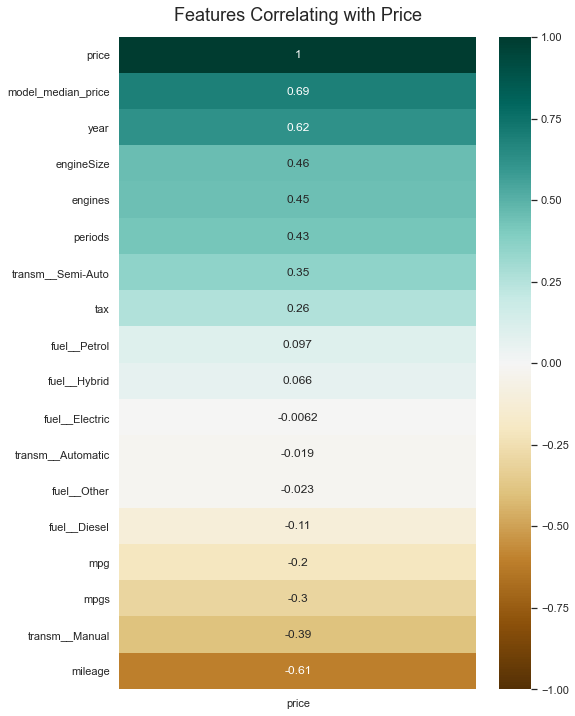

In [720]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':18}, pad=16);

Из тепловой диаграммы мы видим, что на цену наибольшее влияние оказывают:
1. Год выпуска (0.62)
2. Размер двигателя (0.46)
3. Коробка полуавтомат (0.35)
4. Ручная коробка передач (-0.39)
5. Пробег (-0.61)

## Оценка взаимосвязи цены и года выпуска автомобиля в разрезе моделей

Рассмотрим применение коэффициента корреляции на примере анализа зависимости цены от года выпуска машины в разрезе моделей.

In [721]:
model_list = np.unique(df['category'])
model_list

array([' 1 Series', ' 2 Series', ' 3 Series', ' 4 Series', ' 5 Series',
       ' Other sedans', 'I Series', 'M Series', 'SUV', 'Z Series'],
      dtype=object)

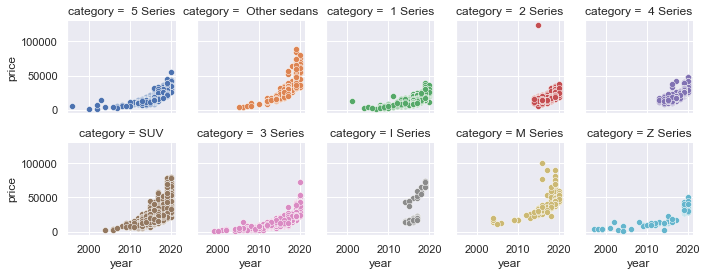

In [722]:
grid = sns.FacetGrid(df, col="category", hue="category", col_wrap=5, height=2)
grid.map(sns.scatterplot, "year", "price")

Влияние года выпуска на стоимость машины сохраняется не зависимо от модели машины. Но степень влияния для каждой модельной группы - разная. Посчитаем коэффициенты корреляции между ценой и годом выпуска для каждой из моделей и сравним их между собой.

<b>Коэффициент корреляции (r)</b> характеризует величину отражающую степень взаимосвязи двух переменных между собой. Он может варьировать в пределах от -1 (отрицательная корреляция) до +1 (положительная корреляция). Если коэффициент корреляции равен 0 то, это говорит об отсутствии корреляционных связей между переменными. Причем если коэффициент корреляции ближе к 1 (или -1) то говориться о сильной корреляции, а если ближе к 0, то о слабой.

In [723]:
corr = []

for item in model_list:
    model = df[['year', 'price', 'category']].loc[(df['category'] == item)]
    corr.append(model['year'].corr(model['price']))
    

corr_df = pd.DataFrame(zip(model_list, corr), columns=['category', 'correlation'])
corr_df.sort_values('correlation')

,category,correlation
6,I Series,0.598029
7,M Series,0.629492
8,SUV,0.654553
1,2 Series,0.671495
0,1 Series,0.755664
5,Other sedans,0.783860
2,3 Series,0.808115
3,4 Series,0.810439
4,5 Series,0.819206
9,Z Series,0.851228


Самая низкая степень влияния года выпуска на цену (но при этом все равно очень сильное, коэффициент корреляции 0.598) в категории электрокаров, а самая высокая - в Z серии.

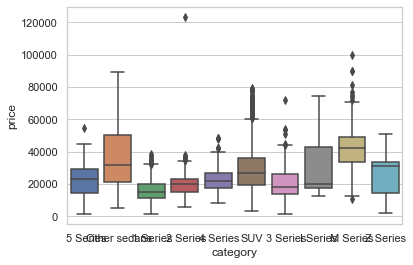

In [724]:
sns.set_style('whitegrid')
sns.boxplot(data = df , x = 'category' , y = 'price')
sns.set(rc={'figure.figsize':(18, 12)})

Средняя цена для каждой группы моделей отличается. Самая низкая средняя цена для 1 серии, самая высокая - для М серии. В группе электрокаров и Z серии есть какие-то выбросы, поэтому средняя смещена. Если бы требовалось для дальнейшего анализа - то стоило бы посмотреть детальнее. Средняя на 3 серию ниже, чем на вторую. Хотя вторая серия изначально позиционируется дешевле третьей, так как это менее мощный и меньший по размерам автомобиль. Но для 3 серии в датасете записей больше и больше машин с более ранним годом выпуска, что и снизило среднюю.

1. Изучаемый датасет содержит информацию о проданных машинах марки BMW, их основных характеристиках и стоимости каждой машины. В базе 10781 запись. 
2. Целевая переменная price - не соответствует признакам нормального распределения.
3. <b>Год выпуска</b> 80.4% записей в датасете описывают машины с годом выпуска 2016 - 2020. И лишь 1.5% - с годом выпуска 1996-2010. При этом 50% машин - с годом выпуска 2017-2019, а 25% - с годом выпуска 2020.
4. <b>Модель</b> Самая представленная модель БМВ 3 серии. К ней относится 22.7% всех записей. Следующая по представленности модель - БМВ 1 серии - 18.3%. При том, что все внедорожники, представленные БМВ (7 моделей) - 22.7%. Самая малочисленная группа моделей - электрокары БМВ (I Серия) - 0.6% всех записей.
5. <b>Коробка передач</b> Неожиданно, но самый распространенный вид коробки передач - полуавтомат (43.4.%), а наименее представленная - ручная (23.4%).
6. <b>Пробег</b> Минимальный пробег - 1 миля, максимальный - 214000 миль. Средний пробег по всей базе 25.5 тыс. миль. 25% машин в базе имеют пробег менее 5600 миль. и более половины машин имеют пробег более 18 тыс. миль.
7. <b>Тип топлива</b> На долю автомобилей с дизельным двигателем приходится 65.2% записей, бензиновым 31.7%. На все остальные виды топлива приходится чуть более 3% записей.
8. <b>Объем двигателя</b> 62% автомобилей, представленных в базе - автомобили с объемом двигателя 1.6 - 2 л. Так как выборка включает в себя незначительное количество электрокаров - присутствуют записи с объем двигателя 0. Также есть несколько неточных записей, где объем двигателя ошибочно указан 0. Максимальный объем двигателя 6.6 л, таких 2 машины в базе.
9. <b>Налог</b> Вообще, очень неоднозначный показатель. Я уверена, что есть вполне себе официальная формула его расчета и он точно зависимый показатель. Я бы его вообще исключила из данных, ну если только не стояла бы задача конкретно по нему. А так - можем только сказать, что он точно зависит от типа двигателя и его объема. Вероятно, еще от цены.
10. <b>Миль на 1 галон топлива</b> Минимальный пробег на 1 галоне топлива - 5.5, максимальный - 470.8. В среднем же, машины, представленные в датасете, могут проехать 56.4 миль на 1 галоне топлива. 75% выборки могут проехать более 45 миль на 1 галон топлива.
11. Цена на а/м зависит от: года выпуска (0.62), размера двигателя (0.46), типа коробки передач (выше на полуавтома 0.35, ниже на ручную -0.39), пробега (-0.61).
12. В модельных группах значительное влияние года выпуска на цену машины сохраняется, при этом самое низкое влияние в группе электрокаров (0.508), самое высокое - в Z-серии (0.85).